In [1]:
from PIL import Image
from pathlib import Path
import glob
import os
from fastai.vision.all import *
import cv2
import json
import numpy as np 

In [2]:
# all relevant file and folder(directory) paths: 
path = Path(os.getcwd())
input_folder = os.path.join(os.getcwd(), "masks_input") # input_folder = folder with exported jsons of all masking data
output_folder = os.path.join(os.getcwd(), "TEM_masks") # output_folder = folder with all generated mask images based on the jsons within the input_folder
fnames = sorted(get_image_files(path/"TEM_images")) # fnames = all filenames of the TEM images for identification of MoS2
fnamesmask = sorted(get_image_files(output_folder)) # all filenames of the mask images
codes_file = os.path.join(os.getcwd(), "codes.txt") # codes file location for segmentation
test_folder = os.path.join(os.getcwd(), "TEM_test_images") # test_folder = folder with 3 images for visually inspecting results of the vision model

In [3]:
# block of code for generating masked images based on the segmentation masking tutorial here: 
# https://towardsdatascience.com/generating-image-segmentation-masks-the-easy-way-dd4d3656dbd1
count = 0                                           # Count of total images saved
file_bbs = {}                                       # Dictionary containing polygon coordinates for mask
MASK_WIDTH = 2048				    # Dimensions should match those of ground truth image
MASK_HEIGHT = 2048									

# Extract X and Y coordinates if available and update dictionary
def add_to_dict(data, itr, key, count):
    try:
        x_points = data[itr]["regions"][count]["shape_attributes"]["all_points_x"]
        y_points = data[itr]["regions"][count]["shape_attributes"]["all_points_y"]
    except:
        print("No BB. Skipping", key)
        return
    
    all_points = []
    for i, x in enumerate(x_points):
        all_points.append([x, y_points[i]])

    return all_points

for file_name in os.listdir(input_folder):
    
# Read JSON file
    with open(input_folder + "/" + file_name) as f:
        data = json.load(f)
    polygons = []
    for itr in data:
        file_name_json = data[itr]["filename"]
        sub_count = 0               # Contains count of masks for a single ground truth image

        if len(data[itr]["regions"]) > 1:
            for _ in range(len(data[itr]["regions"])):
                key = file_name_json[:-4] + "*" + str(sub_count+1)
                polygons.append(add_to_dict(data, itr, key, sub_count))
                sub_count += 1
        else:
            polgons.append(add_to_dict(data, itr, file_name_json[:-4], 0))
        mask = np.zeros((MASK_WIDTH, MASK_HEIGHT))
        for polygon in polygons:
            cv2.fillPoly(mask, [np.array(polygon)], color=(1))
        cv2.imwrite(os.path.join(output_folder, file_name_json)+ ".png", mask)
        polygons = []

In [4]:
# fastai dataloader and ResNet-34 learner using images and masked images
dls = SegmentationDataLoaders.from_label_func(
    path, bs=1, fnames = get_image_files(path/"TEM_images"), item_tfms = Resize(256), batch_tfms=aug_transforms(do_flip=True, flip_vert=True, p_affine=0.75),
    label_func = lambda o: path/"TEM_masks"/f'{o.stem}{o.suffix}.png',
    codes = np.loadtxt(codes_file, dtype=str)
)

mos2_learn = unet_learner(dls, resnet34)
mos2_learn.fit(15)

/home/jab/.pyenv/versions/3.9.4/lib/python3.9/site-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/home/jab/.pyenv/versions/3.9.4/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/jab/.pyenv/versions/3.9.4/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equi

epoch,train_loss,valid_loss,time
0,1.263024,0.707170,00:03
1,0.907171,0.675915,00:03
2,0.798958,0.670266,00:03
3,0.742142,0.641029,00:03
4,0.667421,0.422789,00:03
5,0.594700,0.350620,00:03
6,0.526442,0.374356,00:03
7,0.472743,0.318152,00:03
8,0.430582,0.276082,00:03
9,0.407484,0.364617,00:03


In [5]:
# function for showing images with identified MoS2 results based on vision model identification
def show_imagewmask(filename):
    _,axs = plt.subplots(1,1, figsize=(8,8))
    pil_im = Image.open(filename, mode='r', formats=None).resize((256,256))
    im_array = np.asarray(pil_im)
    plt.imshow(im_array,cmap='gray')
    print(f"Percent of identified MoS2 nanostructure within TEM image: {100* sum(sum(mos2_learn.predict(filename)[1]))/256**2}")
    return(mos2_learn.predict(filename)[0]).show(alpha=0.5,ctx=axs)

Percent of identified MoS2 nanostructure within TEM image: 83.41217041015625


<AxesSubplot:>

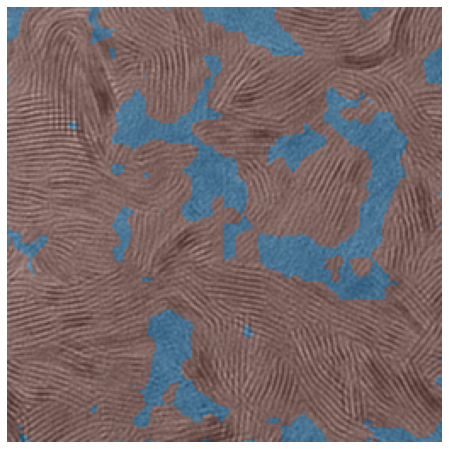

In [6]:
show_imagewmask(os.path.join(test_folder,"395.tif"))

Percent of identified MoS2 nanostructure within TEM image: 42.449951171875


<AxesSubplot:>

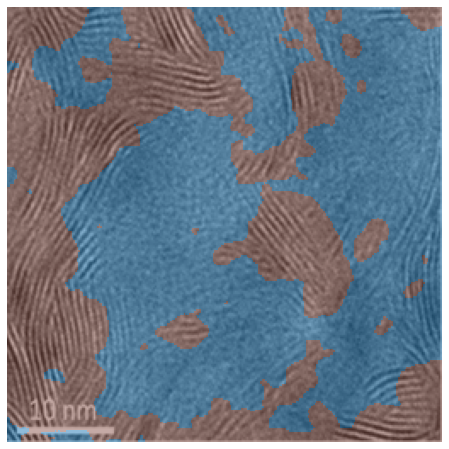

In [7]:
show_imagewmask(os.path.join(test_folder, "example MoS2 2.png"))

Percent of identified MoS2 nanostructure within TEM image: 39.532470703125


<AxesSubplot:>

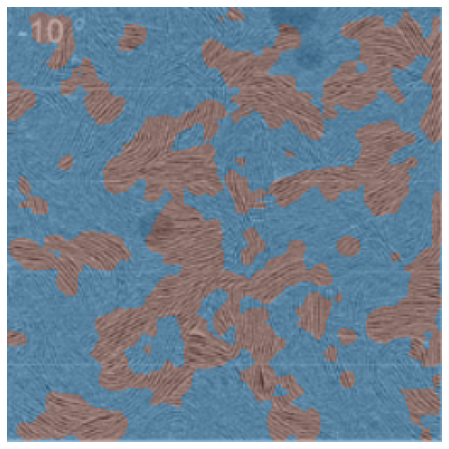

In [8]:
show_imagewmask(os.path.join(test_folder, "screenshot nl400258t_si_001.pdf.png"))